In [3]:
pip install rdkit

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [5]:
# ============================================================================
# IMPORTS
# ============================================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import warnings
import os

# RDKit for feature calculation
from rdkit import Chem
from rdkit.Chem import AllChem  # We use AllChem for Morgan Fingerprints

# Scikit-learn
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, roc_auc_score, confusion_matrix,
                             classification_report, roc_curve)
from xgboost import XGBClassifier

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("=" * 80)
print("VALID SERT INHIBITOR CLASSIFICATION MODEL TRAINING (Morgan Fingerprints)")
print("=" * 80)

# Define Fingerprint parameters
FP_SIZE = 2048
FP_RADIUS = 2

# 1. DATA LOADING
print("\n[STEP 1] Loading Data...")
try:
    df = pd.read_csv('data.csv', delimiter=';')
    print(f" Dataset loaded successfully")
    print(f"  Shape: {df.shape}")
except FileNotFoundError:
    print("Error: 'data.csv' not found. Please place it in the same directory.")
    exit()

VALID SERT INHIBITOR CLASSIFICATION MODEL TRAINING (Morgan Fingerprints)

[STEP 1] Loading Data...
 Dataset loaded successfully
  Shape: (16113, 48)


In [13]:
df.head()

,Molecule ChEMBL ID,Molecule Name,Molecule Max Phase,Molecular Weight,#RO5 Violations,AlogP,Compound Key,Smiles,Standard Type,Standard Relation,...,Document ChEMBL ID,Source ID,Source Description,Document Journal,Document Year,Cell ChEMBL ID,Properties,Action Type,Standard Text Value,Value
0,CHEMBL211372,NaN,NaN,412.57,0.0,4.87,5e,CN1C2CCC1C1COC(=O)CCCCCCCCC(=O)Nc3ccc(cc3)C1C2,Ki,'=',...,CHEMBL1137428,1,Scientific Literature,J Med Chem,2006.0,NaN,NaN,NaN,NaN,1.9
1,CHEMBL4085703,NaN,NaN,346.48,0.0,3.10,4b,COC1NN=C(C[S+]([O-])C(c2ccccc2)c2ccccc2)S1,IC50,NaN,...,CHEMBL4028886,1,Scientific Literature,J Med Chem,2017.0,CHEMBL3307715,NaN,NaN,NaN,NaN
2,CHEMBL4103632,NaN,NaN,328.46,0.0,3.88,4c,Cc1nnc(C[S+]([O-])C(c2ccccc2)c2ccccc2)s1,IC50,NaN,...,CHEMBL4028886,1,Scientific Literature,J Med Chem,2017.0,CHEMBL3307715,NaN,NaN,NaN,NaN
3,CHEMBL4077697,NaN,NaN,307.42,0.0,4.12,7b,[O-][S+](Cc1ccncc1)C(c1ccccc1)c1ccccc1,IC50,NaN,...,CHEMBL4028886,1,Scientific Literature,J Med Chem,2017.0,CHEMBL3307715,NaN,NaN,NaN,NaN
4,CHEMBL4080841,NaN,NaN,322.43,0.0,3.82,7j,Cc1cnc(C[S+]([O-])C(c2ccccc2)c2ccccc2)nc1,IC50,NaN,...,CHEMBL4028886,1,Scientific Literature,J Med Chem,2017.0,CHEMBL3307715,NaN,NaN,NaN,NaN


In [8]:
# 2. DATA CLEANING & PREPROCESSING
print("\n" + "=" * 80)
print("[STEP 2] Data Cleaning & Preprocessing")
print("=" * 80)

df_clean = df[['Smiles', 'Standard Value', 'Standard Relation']].copy()
df_clean = df_clean.dropna(subset=['Smiles', 'Standard Value'])
print(f"✓ Dropped rows with missing SMILES or Standard Value")

df_clean = df_clean[df_clean['Standard Relation'] == "'='"]
print(f"✓ Filtered for '=' relation")

df_clean['Standard Value'] = pd.to_numeric(df_clean['Standard Value'], errors='coerce')
df_clean = df_clean.dropna(subset=['Standard Value'])

df_clean = df_clean.drop_duplicates(subset=['Smiles'])
print(f"✓ Removed duplicate SMILES")
print(f"\nFinal cleaned shape for feature extraction: {df_clean.shape}")


[STEP 2] Data Cleaning & Preprocessing
✓ Dropped rows with missing SMILES or Standard Value
✓ Filtered for '=' relation
✓ Removed duplicate SMILES

Final cleaned shape for feature extraction: (6739, 3)


In [9]:
# ============================================================================
# 3. TARGET CREATION
# ============================================================================
print("\n" + "=" * 80)
print("[STEP 3] Target Creation")
print("=" * 80)

threshold = 100  # nM
df_clean['Activity_Class'] = (df_clean['Standard Value'] < threshold).astype(int)

print(f"✓ Created binary target: Active (<{threshold}nM) = 1, Inactive (>=100nM) = 0")
print(f"\nClass Distribution:")
print(df_clean['Activity_Class'].value_counts(normalize=True))


[STEP 3] Target Creation
✓ Created binary target: Active (<100nM) = 1, Inactive (>=100nM) = 0

Class Distribution:
Activity_Class
1    0.590147
0    0.409853
Name: proportion, dtype: float64


In [14]:
import matplotlib.pyplot as plt
import scipy.stats as stats

def plot_qq(data, column):
    plt.figure(figsize=(6, 6))
    stats.probplot(data[column].dropna(), dist="norm", plot=plt)
    plt.title(f"Q–Q Plot for {column}")
    plt.show()


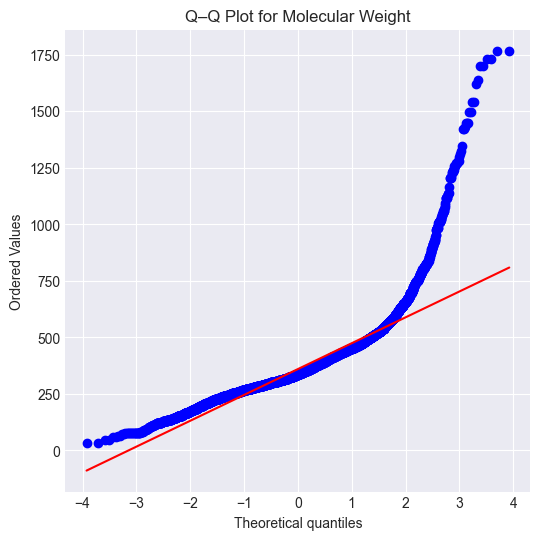

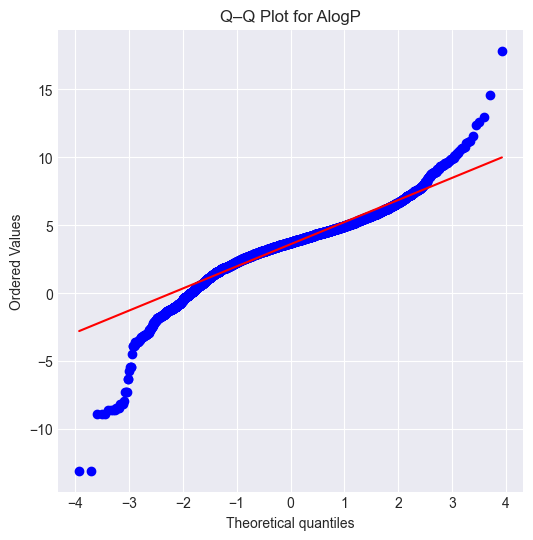

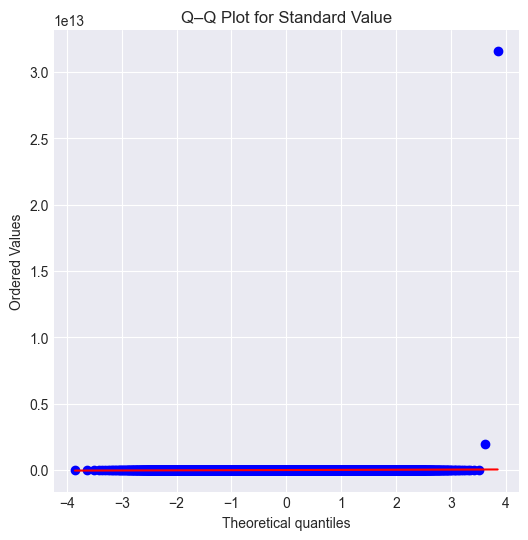

In [17]:
plot_qq(df, 'Molecular Weight')
plot_qq(df, 'AlogP')
plot_qq(df, 'Standard Value')



In [22]:
# ============================================================================
# 4. FEATURE ENGINEERING (SMILES -> Morgan Fingerprints)
# ============================================================================
print("\n" + "=" * 80)
print("[STEP 4] Feature Engineering (Morgan Fingerprints)")
print("=" * 80)

def calculate_morgan_fp(smiles, radius=FP_RADIUS, n_bits=FP_SIZE):
    """
    Calculates a Morgan Fingerprint from a SMILES string.
    """
    try:
        mol = Chem.MolFromSmiles(smiles)
        if mol is None:
            return None

        fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius, nBits=n_bits)
        return np.array(fp)
    except Exception:
        return None

print(f"Calculating Morgan Fingerprints (Radius={FP_RADIUS}, Size={FP_SIZE})...")

fp_list = []
y_list = []
valid_smiles = []

for idx, row in df_clean.iterrows():
    fp = calculate_morgan_fp(row['Smiles'])
    if fp is not None:
        fp_list.append(fp)
        y_list.append(row['Activity_Class'])
        valid_smiles.append(row['Smiles'])

# Create feature matrix X and target vector y
X = np.array(fp_list)
y = np.array(y_list)

print(f"✓ Dropped {len(df_clean) - len(X)} rows with failed RDKit calculation")
print(f"\nFeature matrix shape: {X.shape}")
print(f"Target vector shape: {y.shape}")

# Define a metadata variable for saving
feature_metadata = {
    "type": "MorganFingerprint",
    "radius": FP_RADIUS,
    "size": FP_SIZE
}


[STEP 4] Feature Engineering (Morgan Fingerprints)
Calculating Morgan Fingerprints (Radius=2, Size=2048)...


Streaming output truncated to the last 5000 lines.
[13:54:39] DEPRECATION WARNING: please use MorganGenerator
[13:54:39] DEPRECATION WARNING: please use MorganGenerator
[13:54:39] DEPRECATION WARNING: please use MorganGenerator
[13:54:39] DEPRECATION WARNING: please use MorganGenerator
[13:54:39] DEPRECATION WARNING: please use MorganGenerator
[13:54:39] DEPRECATION WARNING: please use MorganGenerator
[13:54:39] DEPRECATION WARNING: please use MorganGenerator
[13:54:39] DEPRECATION WARNING: please use MorganGenerator
[13:54:39] DEPRECATION WARNING: please use MorganGenerator
[13:54:39] DEPRECATION WARNING: please use MorganGenerator
[13:54:39] DEPRECATION WARNING: please use MorganGenerator
[13:54:39] DEPRECATION WARNING: please use MorganGenerator
[13:54:39] DEPRECATION WARNING: please use MorganGenerator
[13:54:39] DEPRECATION WARNING: please use MorganGenerator
[13:54:39] DEPRECATION WARNING: please use MorganGenerator
[13:54:39] DEPRECATION WARNING: please use MorganGenerator
[13:5

✓ Dropped 0 rows with failed RDKit calculation

Feature matrix shape: (6739, 2048)
Target vector shape: (6739,)


In [24]:
# ============================================================================
# 5. TRAIN-TEST SPLIT (Scaling is not needed for fingerprints)
# ============================================================================
print("\n" + "=" * 80)
print("[STEP 5] Train-Test Split")
print("=" * 80)

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\n✓ Train-Test Split:")
print(f"  Training set: {X_train.shape[0]} samples")
print(f"  Test set: {X_test.shape[0]} samples")
print("\n✓ Scaling is NOT required for binary fingerprints.")


[STEP 5] Train-Test Split

✓ Train-Test Split:
  Training set: 5391 samples
  Test set: 1348 samples

✓ Scaling is NOT required for binary fingerprints.


In [ ]:
# ============================================================================
# 6. MODEL TRAINING
# ============================================================================
print("\n" + "=" * 80)
print("[STEP 6] Model Training")
print("=" * 80)

# Initialize models
models = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'SVM': SVC(random_state=42, probability=True),
    'XGBoost': XGBClassifier(random_state=42, eval_metric='logloss', use_label_encoder=False),
    'Random Forest': RandomForestClassifier(random_state=42),
    'Naive Bayes': GaussianNB(),
    'KNN': KNeighborsClassifier()
}

results = {}
trained_models = {}

print("\nTraining models with 5-Fold Cross-Validation...\n")

for name, model in models.items():
    print(f"Training {name}...")

    # Use X_train directly (no scaling)
    cv_scores = cross_val_score(model, X_train, y_train,
                                cv=5, scoring='accuracy', n_jobs=-1)

    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, 'predict_proba') else None

    results[name] = {
        'model': model,
        'cv_mean': cv_scores.mean(),
        'cv_std': cv_scores.std(),
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred, zero_division=0),
        'recall': recall_score(y_test, y_pred, zero_division=0),
        'f1': f1_score(y_test, y_pred, zero_division=0),
        'roc_auc': roc_auc_score(y_test, y_pred_proba) if y_pred_proba is not None else None,
        'y_pred': y_pred,
        'y_pred_proba': y_pred_proba
    }

    trained_models[name] = model

    print(f"  ✓ CV Accuracy: {cv_scores.mean():.4f} (+/- {cv_scores.std():.4f})")
    print(f"  ✓ Test Accuracy: {results[name]['accuracy']:.4f}\n")


[STEP 6] Model Training

Training models with 5-Fold Cross-Validation...

Training Logistic Regression...
  ✓ CV Accuracy: 0.7652 (+/- 0.0065)
  ✓ Test Accuracy: 0.7767

Training SVM...
  ✓ CV Accuracy: 0.7895 (+/- 0.0103)
  ✓ Test Accuracy: 0.8012

Training XGBoost...
  ✓ CV Accuracy: 0.7845 (+/- 0.0112)
  ✓ Test Accuracy: 0.7967

Training Random Forest...
  ✓ CV Accuracy: 0.8043 (+/- 0.0071)
  ✓ Test Accuracy: 0.8042

Training Naive Bayes...
  ✓ CV Accuracy: 0.6461 (+/- 0.0162)
  ✓ Test Accuracy: 0.6617

Training KNN...
  ✓ CV Accuracy: 0.7529 (+/- 0.0177)
  ✓ Test Accuracy: 0.7663



In [26]:
# ============================================================================
# 7. HYPERPARAMETER TUNING (Best Model)
# ============================================================================
print("\n" + "=" * 80)
print("[STEP 7] Hyperparameter Tuning")
print("=" * 80)

top_models = sorted(results, key=lambda x: results[x]['cv_mean'], reverse=True)[:3]
print(f"\nPerforming GridSearchCV on top 3 models: {top_models}\n")

# Using smaller param grids for faster tuning
param_grids = {
    'Random Forest': {
        'n_estimators': [100, 200],
        'max_depth': [20, None],
        'min_samples_split': [2, 5]
    },
    'XGBoost': {
        'n_estimators': [100, 200],
        'max_depth': [5, 7],
        'learning_rate': [0.05, 0.1]
    },
    'SVM': {
        'C': [1, 10], # SVMs can be slow on high-dim data
        'kernel': ['rbf'],
        'gamma': ['scale']
    },
}

tuned_results = {}

for model_name in top_models:
    if model_name in param_grids:
        print(f"Tuning {model_name}...")

        grid_search = GridSearchCV(
            models[model_name],
            param_grids[model_name],
            cv=3, # Using 3-fold CV for speed with high-dim fingerprints
            scoring='accuracy',
            n_jobs=-1,
            verbose=1
        )
        grid_search.fit(X_train, y_train)

        print(f"  Best parameters: {grid_search.best_params_}")
        print(f"  Best CV score: {grid_search.best_score_:.4f}")

        y_pred_tuned = grid_search.predict(X_test)
        y_pred_proba_tuned = grid_search.predict_proba(X_test)[:, 1] if hasattr(grid_search, 'predict_proba') else None

        tuned_results[model_name] = {
            'model': grid_search.best_estimator_,
            'cv_mean': grid_search.best_score_,
            'accuracy': accuracy_score(y_test, y_pred_tuned),
            'precision': precision_score(y_test, y_pred_tuned, zero_division=0),
            'recall': recall_score(y_test, y_pred_tuned, zero_division=0),
            'f1': f1_score(y_test, y_pred_tuned, zero_division=0),
            'roc_auc': roc_auc_score(y_test, y_pred_proba_tuned) if y_pred_proba_tuned is not None else None,
            'y_pred': y_pred_tuned,
            'y_pred_proba': y_pred_proba_tuned
        }

        print(f"  Tuned Test Accuracy: {tuned_results[model_name]['accuracy']:.4f}\n")


[STEP 7] Hyperparameter Tuning

Performing GridSearchCV on top 3 models: ['Random Forest', 'SVM', 'XGBoost']

Tuning Random Forest...
Fitting 3 folds for each of 8 candidates, totalling 24 fits
  Best parameters: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200}
  Best CV score: 0.7995
  Tuned Test Accuracy: 0.8108

Tuning SVM...
Fitting 3 folds for each of 2 candidates, totalling 6 fits
  Best parameters: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
  Best CV score: 0.7876
  Tuned Test Accuracy: 0.7997

Tuning XGBoost...
Fitting 3 folds for each of 8 candidates, totalling 24 fits
  Best parameters: {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 200}
  Best CV score: 0.7817
  Tuned Test Accuracy: 0.7938



In [27]:
# ============================================================================
# 8. PERFORMANCE METRICS & COMPARISON
# ============================================================================
print("\n" + "=" * 80)
print("[STEP 8] Performance Metrics Summary")
print("=" * 80)

for name, tuned_data in tuned_results.items():
    results[name] = tuned_data
    trained_models[name] = tuned_data['model']

metrics_df = pd.DataFrame({
    'Model': list(results.keys()),
    'CV Accuracy': [results[m]['cv_mean'] for m in results],
    'Test Accuracy': [results[m]['accuracy'] for m in results],
    'Precision': [results[m]['precision'] for m in results],
    'Recall': [results[m]['recall'] for m in results],
    'F1-Score': [results[m]['f1'] for m in results],
    'ROC-AUC': [results[m]['roc_auc'] if results[m]['roc_auc'] else 0 for m in results]
})

metrics_df = metrics_df.sort_values('Test Accuracy', ascending=False)
print("\n--- Final Model Performance ---")
print(metrics_df.to_string(index=False))

os.makedirs('valid_fp_model_files', exist_ok=True)
metrics_path = 'valid_fp_model_files/model_performance_metrics.csv'
metrics_df.to_csv(metrics_path, index=False)
print(f"\n✓ Metrics saved to '{metrics_path}'")




[STEP 8] Performance Metrics Summary

--- Final Model Performance ---
              Model  CV Accuracy  Test Accuracy  Precision   Recall  F1-Score  ROC-AUC
      Random Forest     0.799481       0.810831   0.827086 0.859296  0.842884 0.876500
                SVM     0.787609       0.799703   0.825495 0.837940  0.831671 0.870816
            XGBoost     0.781673       0.793769   0.812048 0.846734  0.829028 0.863172
Logistic Regression     0.765164       0.776706   0.808989 0.814070  0.811522 0.847044
                KNN     0.752925       0.766320   0.811125 0.787688  0.799235 0.844743
        Naive Bayes     0.646073       0.661721   0.793103 0.577889  0.668605 0.746819

✓ Metrics saved to 'valid_fp_model_files/model_performance_metrics.csv'



[STEP 9] Generating Visualizations


KeyError: 'cv_std'

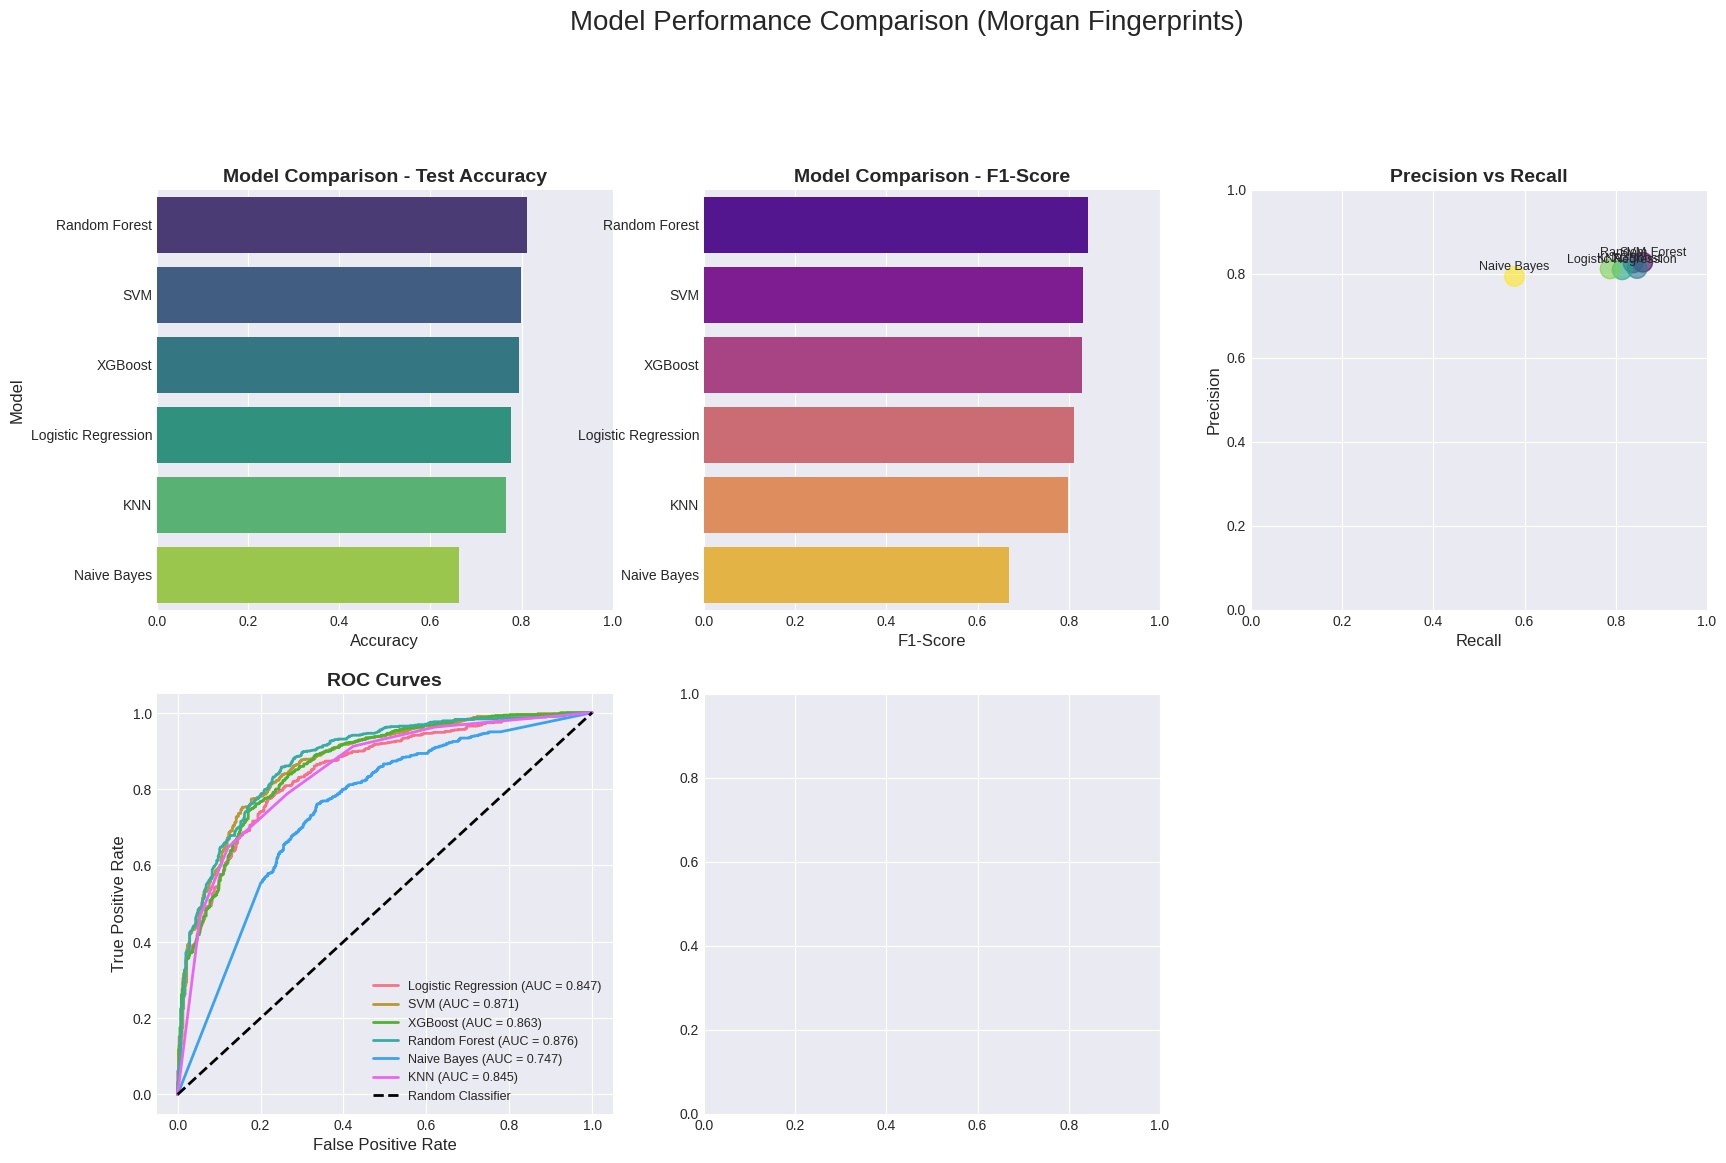

In [28]:

# ============================================================================
# 9. VISUALIZATION
# ============================================================================
print("\n" + "=" * 80)
print("[STEP 9] Generating Visualizations")
print("=" * 80)

fig = plt.figure(figsize=(20, 12))
plt.suptitle("Model Performance Comparison (Morgan Fingerprints)", fontsize=20, y=1.03)

# 1. Model Comparison - Accuracy
ax1 = plt.subplot(2, 3, 1)
sns.barplot(data=metrics_df, x='Test Accuracy', y='Model', ax=ax1, palette='viridis')
ax1.set_title('Model Comparison - Test Accuracy', fontsize=14, fontweight='bold')
ax1.set_xlabel('Accuracy', fontsize=12)
ax1.set_ylabel('Model', fontsize=12)
ax1.set_xlim([0, 1])

# 2. Model Comparison - F1-Score
ax2 = plt.subplot(2, 3, 2)
sns.barplot(data=metrics_df, x='F1-Score', y='Model', ax=ax2, palette='plasma')
ax2.set_title('Model Comparison - F1-Score', fontsize=14, fontweight='bold')
ax2.set_xlabel('F1-Score', fontsize=12)
ax2.set_ylabel('')
ax2.set_xlim([0, 1])

# 3. Precision vs Recall
ax3 = plt.subplot(2, 3, 3)
ax3.scatter(metrics_df['Recall'], metrics_df['Precision'], s=200, alpha=0.6, c=range(len(metrics_df)), cmap='viridis')
for i, model in enumerate(metrics_df['Model']):
    ax3.annotate(model, (metrics_df['Recall'].iloc[i], metrics_df['Precision'].iloc[i]),
                fontsize=9, ha='center', xytext=(0, 5), textcoords='offset points')
ax3.set_xlabel('Recall', fontsize=12)
ax3.set_ylabel('Precision', fontsize=12)
ax3.set_title('Precision vs Recall', fontsize=14, fontweight='bold')
ax3.set_xlim([0, 1])
ax3.set_ylim([0, 1])

# 4. ROC Curves
ax4 = plt.subplot(2, 3, 4)
for name in results:
    if results[name]['y_pred_proba'] is not None:
        fpr, tpr, _ = roc_curve(y_test, results[name]['y_pred_proba'])
        auc_score = results[name]['roc_auc']
        ax4.plot(fpr, tpr, label=f'{name} (AUC = {auc_score:.3f})', linewidth=2)
ax4.plot([0, 1], [0, 1], 'k--', label='Random Classifier', linewidth=2)
ax4.set_xlabel('False Positive Rate', fontsize=12)
ax4.set_ylabel('True Positive Rate', fontsize=12)
ax4.set_title('ROC Curves', fontsize=14, fontweight='bold')
ax4.legend(loc='lower right', fontsize=9)

# 5. Cross-Validation Scores
ax5 = plt.subplot(2, 3, 5)
cv_data = metrics_df.sort_values('CV Accuracy', ascending=False)
sns.barplot(data=cv_data, x='CV Accuracy', y='Model', ax=ax5, palette='cubehelix', xerr=metrics_df['cv_std'])
ax5.set_xlabel('CV Accuracy (Mean ± Std)', fontsize=12)
ax5.set_title('Cross-Validation Scores', fontsize=14, fontweight='bold')
ax5.set_ylabel('')
ax5.set_xlim([0, 1])

# 6. Confusion Matrix for Best Model
ax6 = plt.subplot(2, 3, 6)
best_model_name = metrics_df.iloc[0]['Model']
cm = confusion_matrix(y_test, results[best_model_name]['y_pred'])
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax6, cbar=True,
            xticklabels=['Inactive', 'Active'], yticklabels=['Inactive', 'Active'])
ax6.set_title(f'Confusion Matrix - {best_model_name}', fontsize=14, fontweight='bold')
ax6.set_ylabel('True Label', fontsize=12)
ax6.set_xlabel('Predicted Label', fontsize=12)

plt.tight_layout()
viz_path = 'valid_fp_model_files/model_comparison_plots.png'
plt.savefig(viz_path, dpi=300, bbox_inches='tight')
print(f"✓ Visualization saved as '{viz_path}'")
plt.close(fig)

# Feature importance plot is omitted as 2048 bits are not human-readable
print("✓ Feature importance plot skipped (not meaningful for 2048-bit fingerprints).")

In [29]:
# ============================================================================
# 10. MODEL SELECTION & SAVING
# ============================================================================
print("\n" + "=" * 80)
print("[STEP 10] Saving Best Model")
print("=" * 80)

best_model_name = metrics_df.iloc[0]['Model']
best_model = trained_models[best_model_name]

print(f"\nBest Model: {best_model_name}")
print(f"Test Accuracy: {metrics_df.iloc[0]['Test Accuracy']:.4f}")
print(f"F1-Score: {metrics_df.iloc[0]['F1-Score']:.4f}")
print(f"ROC-AUC: {metrics_df.iloc[0]['ROC-AUC']:.4f}")

# Save the best model
model_path = 'valid_fp_model_files/best_model.pkl'
with open(model_path, 'wb') as f:
    pickle.dump(best_model, f)
print(f"\n✓ Best model saved as '{model_path}'")

# Save model metadata
model_metadata = {
    'best_model_name': best_model_name,
    'features': feature_metadata, # Save the fingerprint parameters
    'metrics': metrics_df.iloc[0].to_dict(),
    'threshold': threshold,
    'scaler_path': None # No scaler was used
}

metadata_path = 'valid_fp_model_files/model_metadata.pkl'
with open(metadata_path, 'wb') as f:
    pickle.dump(model_metadata, f)
print(f"✓ Model metadata saved as '{metadata_path}'")


[STEP 10] Saving Best Model

Best Model: Random Forest
Test Accuracy: 0.8108
F1-Score: 0.8429
ROC-AUC: 0.8765

✓ Best model saved as 'valid_fp_model_files/best_model.pkl'
✓ Model metadata saved as 'valid_fp_model_files/model_metadata.pkl'


In [32]:
# ============================================================================
# 11. FINAL SUMMARY
# ============================================================================
print("\n" + "=" * 80)
print("TRAINING COMPLETE!")
print("=" * 80)

print("\nGenerated Files in 'valid_fp_model_files/':")
print("  1. best_model.pkl - Best performing model")
print("  2. model_metadata.pkl - Model configuration and feature list")
print("  3. model_performance_metrics.csv - Performance metrics")
print("  4. model_comparison_plots.png - Visualization")

print("\nTo use this model in your Streamlit app:")
print("1. Copy 'best_model.pkl' and 'model_metadata.pkl' to your app directory.")
print("2. Update your app to load these files.")
print("3. Ensure your app's 'calculate_morgan_fp' function uses the same parameters:")
print(f"   (Radius={FP_RADIUS}, Size={FP_SIZE})")
print("4. Your app's prediction logic should NOT use a scaler:")
# Example app logic:
#features_array = calculate_morgan_fp(smiles).reshape(1, -1)
# NO SCALING STEP NEEDED
#prediction = model.predict(features_array)
#probability = model.predict_proba(features_array)

print("\n" + "=" * 80)
print("Ready for deployment!")
print("=" * 80)


TRAINING COMPLETE!

Generated Files in 'valid_fp_model_files/':
  1. best_model.pkl - Best performing model
  2. model_metadata.pkl - Model configuration and feature list
  3. model_performance_metrics.csv - Performance metrics
  4. model_comparison_plots.png - Visualization

To use this model in your Streamlit app:
1. Copy 'best_model.pkl' and 'model_metadata.pkl' to your app directory.
2. Update your app to load these files.
3. Ensure your app's 'calculate_morgan_fp' function uses the same parameters:
   (Radius=2, Size=2048)
4. Your app's prediction logic should NOT use a scaler:

Ready for deployment!
